# INFO370 Problem Set 6: Linear Regression
Group Member: Martin Zhang, Daisy Du, Leon Tan, Sailesh Sivikumar

In [1872]:
import pandas as pd
import numpy as np
import re
import math

## 1 Data description

In [1873]:
data = pd.read_csv('airbnb-seattle-listings-train.csv',sep='\t')
pd.options.display.max_columns = 106
pd.options.display.max_rows = 40
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20190922030624,2019-09-22,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,Madrona is a hidden gem of a neighborhood. It ...,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,We are a family who live next door and are ava...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/02973ad3-a...,NaN,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/016a1...,https://a0.muscache.com/im/pictures/user/016a1...,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.61082,-122.29082,t,House,Entire home/apt,9,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""""Free parking on premi...",NaN,$296.00,NaN,NaN,$500.00,$250.00,8,$25.00,30,1000,30,30,1000,1000,30.0,1000.0,5 days ago,t,25,55,84,84,2019-09-22,28,8,2008-09-15,2019-08-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,"{WASHINGTON,"""" Seattle"""","""" WA""""}",f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.21
1,5682,https://www.airbnb.com/rooms/5682,20190922030624,2019-09-22,"Cozy Studio, min. to downtown -WiFi",The Cozy Studio is a perfect launchpad for you...,"Hello fellow travelers, Save some money and ha...",The Cozy Studio is a perfect launchpad for you...,none,NaN,My personal favorite places to dine are: • Ma...,Bus 120 is right outside and goes into downtow...,PRIVATE ENTRANCE WITH PRIVATE BATH Queen size ...,"I'm more than happy to meet with guests, but u...",**PLEASE READ** NO SMOKING NO VAPING NO MARIJU...,NaN,NaN,https://a0.muscache.com/im/pictures/5ec89f9d-8...,NaN,8993,https://www.airbnb.com/users/show/8993,Maddy,2009-03-03,"Seattle, Washington, United States",Hello my name is Maddy. I enjoy meeting and ho...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/8993/profile_...,https://a0.muscache.com/im/users/8993/profile_...,South Delridge,1.0,1.0,

In [1874]:
#assume price is not null. Takes in a list of price string and return integer without dollar sign
def priceConverter(li:list):
    res = []
    for i in li:
        #erase potential comma in the string
        i = float(i[1:].replace(',',''))
        res.append(int(i))
    return res
#takes in a string and return a float
def convertStringToNumeric(n:str): 
    return float(re.sub('\$|\%|,','',n))
#takes in a string, convert to digits
from datetime import datetime
def time_dff(time):
    #if (type(time) == float):
        #print(time)
    return abs((datetime.strptime(time, '%Y-%m-%d') - datetime(2019, 12, 3, 0, 0)).days)
#convert t/f to 1/0. Keep Null
def tfToNumeric(s):
    if s == 't':
        res = 1
    elif s == 'f':
        res = 0
    else:
        res = float('nan')
    return res
def ifNANReturnOther(x):
    if(math.isnan(x)):
        return 'Other'
    return x
def ifNullReturnOther(x):
    if(x is None):
        return 'Other'
    return x
def uniqueValsToCoefficients(dataset,colname):
    uniqueMeans=data.groupby(colname)['price'].mean().sort_values(ascending=True)
    #divide list into thirds, alter dataset[colname] anything within top 2 lists gets a value
    dataset[colname]=dataset[colname].apply(ifNullReturnOther)
    midTierStart=int(len(uniqueMeans)/3)
    topTierStart=int(midTierStart*2)
    listLen=len(uniqueMeans)
    listNames=uniqueMeans.index.tolist()
    topTierTypes=listNames[topTierStart:listLen]
    midTierTypes=listNames[midTierStart:topTierStart]
    
    highTierName=colname+'_highTier'
    midTierName=colname+'_midTier'

    dataset[highTierName]=dataset[colname].apply(lambda x:int(x in topTierTypes))
    dataset[midTierName]=dataset[colname].apply(lambda x:int(x in midTierTypes))
def calendar_ToNumeric(s):
    if (s == 'never'):
        return 0
    elif (s in ['today', 'yesterday'] or "days" in s):
        return 1
    elif ("weeks" in s):
        return 2
    else:
        return 3
def cancel_policyToNumeric(s:str):
    if s == "flexible" or s == "moderate":
        res = 0
    elif s == "strict" or "strict_14_with_grace_period" or "super_strict_30":
        res = 1
    elif s == "super_strict_60":
        res = 2
    else:
        res = float('nan')
    return res

### 1.1 Describe Data

In [1875]:
GatewoodPrice = priceConverter(list(data[data.neighbourhood == 'Gatewood'].price))
BelltownPrice = priceConverter(list(data[data.neighbourhood == 'Belltown'].price))
GateWood_avg = round(np.mean(GatewoodPrice),2)
Belltown_avg = round(np.mean(BelltownPrice),2)
print("location is apparently a signigicant factor. Belltown's average rent price is %s, while for Gatewood is %s." %(Belltown_avg,GateWood_avg)
)

location is apparently a signigicant factor. Belltown's average rent price is 222.16, while for Gatewood is 119.18.


### 1.2 handle missing data

If data is missing siginificantly(e.g. square feet), we choose to not consider the column and instead using some other measurment that can in some degree cover up the loss of this part of data. For example we can use property_type, bedroom, and bathroom.

In [1876]:
#takes in a pandas DataFrame, narrow down the useful columns
def narrowData(data):
    #run a quick check on input type
    if type(data) != pd.DataFrame:
        raise TypeError('Expecting pandas dataframe as input')
    #delete column contains url and id, because they don't provide much information. 
    #Now we need to focus on the other data that are not useful.
    data = data[data.columns.drop(list(data.filter(regex='url')))]
    data = data[data.columns.drop(list(data.filter(regex='id')))]
    #delete column contains calculated information
    data = data[data.columns.drop(list(data.filter(regex='calculated')))]
    #drop useless data by category.
    data = data.drop(['country_code', 'smart_location', 'latitude', 'longitude',
                      'city', 'state', 'zipcode', 'market', 'country', 'host_name', 
                      'host_location', 'jurisdiction_names', 'street'], axis = 1)
    data = data.drop(['name', 'summary', 'space', 'description'], axis = 1)
    data = data.drop(['experiences_offered', 'notes', 'interaction', 'host_about'], axis = 1)
    data = data.drop(['neighbourhood', 'host_neighbourhood', 'neighbourhood_cleansed', 'minimum_minimum_nights', 'maximum_minimum_nights',
                      'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                      'maximum_nights_avg_ntm', 'neighborhood_overview'], axis = 1)
    data = data.drop(['number_of_reviews_ltm', 'first_review', 'last_review', 
                      'host_listings_count'], axis = 1)
    data = data.drop(['last_scraped'], axis = 1)
    data = data.drop(['require_guest_phone_verification'], axis = 1)
    data = data.drop(['review_scores_value', 'review_scores_rating', 'review_scores_accuracy'], axis = 1)
    #drop these columns as more than 80% are missing, so we don't consider inmputation
    data = data.drop(['host_acceptance_rate'], axis = 1)
    data['square_feet'].isnull().value_counts()
    data = data.drop(['square_feet'], axis = 1)
    data['weekly_price'].isnull().value_counts()
    data = data.drop(['weekly_price'], axis = 1)
    data['monthly_price'].isnull().value_counts()
    data = data.drop(['monthly_price'], axis = 1)
    data['license'].isnull().value_counts()
    data = data.drop(['license'], axis = 1)

    #drop these coumns are they only have a single unique value.
    data['has_availability'].unique()
    data = data.drop(['has_availability'], axis = 1)
    data['calendar_last_scraped'].unique()
    data = data.drop(['calendar_last_scraped'], axis = 1)
    data['is_business_travel_ready'].unique()
    data = data.drop(['is_business_travel_ready'], axis = 1)

    #Availability_30, _60, _90 and _365 are highly correlated so we only need to keep one which is Availability__365;
    #host response time is same as the host response rate but less informative and consistent.
    data = data.drop(['availability_30', 'availability_60', 'availability_90', 'host_response_time'], axis = 1)

    #drop duplicated rows.
    data.duplicated(subset=None, keep='first').value_counts()
    data.drop_duplicates(subset=None, keep='first', inplace=True)
    return data

In [1877]:
data = narrowData(data)

### 1.3 Columns to use for training

In [1878]:
data.columns

Index(['transit', 'access', 'house_rules', 'host_since', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_365', 'number_of_reviews', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'reviews_per_month'],
      dtype='object')

Clean Up Data

In [1879]:
#Clean the remaining columns
def cleanData(data):
    #run a quick check on input type
    if type(data) != pd.DataFrame:
        raise TypeError('Expecting pandas dataframe as input')
    #clean price using aforementioned method
    data['price'] = priceConverter(data['price'])
    #Replacing following data with the length of their description and 0 if the value is Nan. 
    #This assumes that the description length positively correlated with accessbility and amenities(True for most cases)
    data['access'] = [len(access) if (type(access) == str) else 0 for access in data['access']]

    data['amenities'] = [re.sub(r'[^a-zA-Z]', '', amenity) for amenity in data['amenities']]
    data['amenities'] = [len(amenity) if (type(amenity) == str) else 0 for amenity in data['amenities']]

    set([type(access) for access in data['transit']])
    data['transit'] = [len(transit) if (type(transit) == str) else 0 for transit in data['transit']]

    set([type(rule) for rule in data['house_rules']])
    data['house_rules'] = [len(house_rule) if (type(house_rule) == str) else 0 for house_rule in data['house_rules']]

    data['host_verifications'] = [re.sub(r'[^a-zA-Z]', '', v) for v in data['host_verifications']]
    data['host_verifications'] = [len(v) for v in data['host_verifications']]
    
    #find host_since by counting the date
    set([type(rule) for rule in data['host_since']])
    data['host_since'] = [time_dff(time) if type(time) == str else time for time in data['host_since']]
    
    #Convert String to float data. Function is on top
    data['host_response_rate'] = [convertStringToNumeric(r) if (type(r) == str) else r for r in data['host_response_rate']]
    data['security_deposit'] = [convertStringToNumeric(s) if (type(s) == str) else s for s in data['security_deposit']]
    data['cleaning_fee'] = [convertStringToNumeric(s) if (type(s) == str) else s for s in data['cleaning_fee']]
    data['extra_people'] = [convertStringToNumeric(s) if (type(s) == str) else s for s in data['extra_people']]
    
    #convert t/f to 1/0. Keep Null
    data['host_is_superhost'] = [tfToNumeric(s) for s in data['host_is_superhost']]
    data['host_has_profile_pic'] = [tfToNumeric(s) for s in data['host_has_profile_pic']]
    data['is_location_exact'] = [tfToNumeric(s) for s in data['is_location_exact']]
    data['require_guest_profile_picture'] = [tfToNumeric(s) for s in data['require_guest_profile_picture']]
    data['requires_license'] = [tfToNumeric(s) for s in data['requires_license']]
    data['instant_bookable'] = [tfToNumeric(s) for s in data['instant_bookable']]
    
    #categorize neighborhood area
    data.loc[:,'neighbourhood_group_cleansed_downtown'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Downtown'))
    data.loc[:,'neighbourhood_group_cleansed_capHill'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Capitol Hill'))
    data.loc[:,'neighbourhood_group_cleansed_beaconHill'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Beacon Hill'))
    data.loc[:,'neighbourhood_group_cleansed_delridge'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Delridge'))
    data.loc[:,'neighbourhood_group_cleansed_queenAnne'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Queen Anne'))
    data.loc[:,'neighbourhood_group_cleansed_northGate'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Northgate'))
    data.loc[:,'neighbourhood_group_cleansed_rainierValley'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Rainier Valley'))
    data.loc[:,'neighbourhood_group_cleansed_lakeCity'] = data.loc[:,'neighbourhood_group_cleansed'].apply(lambda x: int(x=='Lake City'))

    #then drop the origional column
    data = data.drop(['neighbourhood_group_cleansed'], axis = 1)
    
    #run the column for categorical data, then drop column
    uniqueValsToCoefficients(data,'property_type')
    uniqueValsToCoefficients(data, 'room_type')
    uniqueValsToCoefficients(data, 'bed_type')
    data = data.drop(['property_type','room_type', 'bed_type'], axis = 1)
    
    data['calendar_updated'] = [calendar_ToNumeric(s) for s in data['calendar_updated']]
    data['cancellation_policy'] = data['cancellation_policy'].apply(cancel_policyToNumeric)
    return data

In [1880]:
data = cleanData(data)

We need to take look at the host related variables with their p values to decide. 

In [1881]:
#seperate price from data
price = np.array(data['price'])
data = data.drop(columns=['price'])

#standarize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data.values )
data_scaled = pd.DataFrame(scaled,columns = data.columns)

In [1882]:
data_scaled

,transit,access,house_rules,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,number_of_reviews,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,neighbourhood_group_cleansed_downtown,neighbourhood_group_cleansed_capHill,neighbourhood_group_cleansed_beaconHill,neighbourhood_group_cleansed_delridge,neighbourhood_group_cleansed_queenAnne,neighbourhood_group_cleansed_northGate,neighbourhood_group_cleansed_rainierValley,neighbourhood_group_cleansed_lakeCity,property_type_highTier,property_type_midTier,room_type_highTier,room_type_midTier,bed_type_highTier,bed_type_midTier
0,-0.898376,-0.565685,-0.901891,2.995117,0.239581,1.172435,-0.314436,1.112095,0.030606,0.437963,2.321368,1.802867,2.555404,1.355541,0.481366,0.618097,2.633207,3.569330,0.630793,1.650854,0.725866,-1.185655,-0.418482,-0.293429,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.951498,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
1,3.006518,1.289730,0.627019,2.756559,NaN,1.172435,-0.317132,2.269643,0.030606,0.437963,-0.730757,-0.473718,-1.351478,-0.587852,-0.208495,-0.354899,-0.524986,-0.592848,-0.378772,-0.119968,-1.084223,1.173671,-1.056795,5.644523,0.484949,0.287418,0.280738,-1.415572,0.044823,-1.021758,1.158219,-0.238302,0.692016,-0.467762,-0.338238,-0.191635,5.898666,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
2,0.433193,-0.445275,1.235948,2.555868,0.239581,1.172435,-0.298262,0.285276,0.030606,0.437963,-0.730757,2.561728,-0.374758,-0.587852,0.390252,-0.406109,-1.064190,-0.592848,0.126010,-0.185554,-0.999777,-0.005992,1.716826,1.293674,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,-0.863395,4.196362,-0.481922,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433
3,-0.293118,1.076275,1.734162,2.554606,0.239581,1.172435,-0.309045,-1.078977,0.030606,0.437963,-0.730757,-0.473718,-0.374758,-0.587852,1.600762,-0.662160,-0.524986,-0.592848,0.126010,-0.119968,-1.056686,-1.185655,0.083049,5.384567,0.484949,0.287418,0.280738,0.344611,0.044823,0.978705,-0.863395,-0.238302,0.531143,2.137841,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,-1.873324,1.966539,0.092157,-0.0433
4,-0.054919,0.665785,1.114689,2.550819,0.239581,1.172435,-0.314436,-1.078977,0.030606,0.437963,0.141279,-0.473718,0.601963,0.707744,0.201517,0.105994,0.630451,0.001749,-0.126381,-0.119968,-0.439861,-1.185655,1.557248,-0.170291,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.873235,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,0.628438,-0.784613,-0.901891,-0.160410,NaN,-0.852926,-0.319827,0.326617,0.030606,0.437963,0.141279,-0.473718,0.601963,0.059946,-1.275826,NaN,NaN,-0.592848,-0.631164,-0.251140,-1.082387,-1.185655,0.166638,-0.676522,NaN,NaN,NaN,NaN,0.044823,0.978705,-0.863395,-0.238302,NaN,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433
7477,0.066133,-0.598524,-0.901891,1.216662,NaN,-0.852926,-0.317132,-0.169475,0.030606,-2.283299,1.885350,1.802867,2.555404,1.355541,-0.781209,NaN,NaN,-0.592848,-0.631164,0.601478,0.955340,-1.185655,-0.22090

In [1883]:
missing_solution_1 = data_scaled.copy()
missing_solution_2 = data_scaled.copy()

In [1884]:
missing_solution_1

,transit,access,house_rules,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,number_of_reviews,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,neighbourhood_group_cleansed_downtown,neighbourhood_group_cleansed_capHill,neighbourhood_group_cleansed_beaconHill,neighbourhood_group_cleansed_delridge,neighbourhood_group_cleansed_queenAnne,neighbourhood_group_cleansed_northGate,neighbourhood_group_cleansed_rainierValley,neighbourhood_group_cleansed_lakeCity,property_type_highTier,property_type_midTier,room_type_highTier,room_type_midTier,bed_type_highTier,bed_type_midTier
0,-0.898376,-0.565685,-0.901891,2.995117,0.239581,1.172435,-0.314436,1.112095,0.030606,0.437963,2.321368,1.802867,2.555404,1.355541,0.481366,0.618097,2.633207,3.569330,0.630793,1.650854,0.725866,-1.185655,-0.418482,-0.293429,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.951498,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
1,3.006518,1.289730,0.627019,2.756559,NaN,1.172435,-0.317132,2.269643,0.030606,0.437963,-0.730757,-0.473718,-1.351478,-0.587852,-0.208495,-0.354899,-0.524986,-0.592848,-0.378772,-0.119968,-1.084223,1.173671,-1.056795,5.644523,0.484949,0.287418,0.280738,-1.415572,0.044823,-1.021758,1.158219,-0.238302,0.692016,-0.467762,-0.338238,-0.191635,5.898666,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
2,0.433193,-0.445275,1.235948,2.555868,0.239581,1.172435,-0.298262,0.285276,0.030606,0.437963,-0.730757,2.561728,-0.374758,-0.587852,0.390252,-0.406109,-1.064190,-0.592848,0.126010,-0.185554,-0.999777,-0.005992,1.716826,1.293674,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,-0.863395,4.196362,-0.481922,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433
3,-0.293118,1.076275,1.734162,2.554606,0.239581,1.172435,-0.309045,-1.078977,0.030606,0.437963,-0.730757,-0.473718,-0.374758,-0.587852,1.600762,-0.662160,-0.524986,-0.592848,0.126010,-0.119968,-1.056686,-1.185655,0.083049,5.384567,0.484949,0.287418,0.280738,0.344611,0.044823,0.978705,-0.863395,-0.238302,0.531143,2.137841,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,-1.873324,1.966539,0.092157,-0.0433
4,-0.054919,0.665785,1.114689,2.550819,0.239581,1.172435,-0.314436,-1.078977,0.030606,0.437963,0.141279,-0.473718,0.601963,0.707744,0.201517,0.105994,0.630451,0.001749,-0.126381,-0.119968,-0.439861,-1.185655,1.557248,-0.170291,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.873235,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,0.628438,-0.784613,-0.901891,-0.160410,NaN,-0.852926,-0.319827,0.326617,0.030606,0.437963,0.141279,-0.473718,0.601963,0.059946,-1.275826,NaN,NaN,-0.592848,-0.631164,-0.251140,-1.082387,-1.185655,0.166638,-0.676522,NaN,NaN,NaN,NaN,0.044823,0.978705,-0.863395,-0.238302,NaN,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433
7477,0.066133,-0.598524,-0.901891,1.216662,NaN,-0.852926,-0.317132,-0.169475,0.030606,-2.283299,1.885350,1.802867,2.555404,1.355541,-0.781209,NaN,NaN,-0.592848,-0.631164,0.601478,0.955340,-1.185655,-0.22090

Two ways to deal with missing value. 1) Imputation 2) Add another column next to existing column to determine if it is null or not 

Missing Value Solution 1

In [1885]:
from missingpy import KNNImputer
imputer = KNNImputer()
for colName in missing_solution_1.columns:
    if missing_solution_1[colName].isnull().values.any():
        missing_solution_1[colName] = imputer.fit_transform(missing_solution_1[colName].values.reshape(-1,1))
missing_solution_1

/opt/anaconda3/lib/python3.7/site-packages/missingpy/knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
/opt/anaconda3/lib/python3.7/site-packages/missingpy/knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
/opt/anaconda3/lib/python3.7/site-packages/missingpy/knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
/opt/anaconda3/lib/python3.7/site-packages/missingpy/knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
/opt/anaconda3/lib/python3.7/site-packages/missingpy/knnimpute.py:224: U

,transit,access,house_rules,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,number_of_reviews,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,neighbourhood_group_cleansed_downtown,neighbourhood_group_cleansed_capHill,neighbourhood_group_cleansed_beaconHill,neighbourhood_group_cleansed_delridge,neighbourhood_group_cleansed_queenAnne,neighbourhood_group_cleansed_northGate,neighbourhood_group_cleansed_rainierValley,neighbourhood_group_cleansed_lakeCity,property_type_highTier,property_type_midTier,room_type_highTier,room_type_midTier,bed_type_highTier,bed_type_midTier
0,-0.898376,-0.565685,-0.901891,2.995117,2.395810e-01,1.172435,-0.314436,1.112095,0.030606,0.437963,2.321368,1.802867,2.555404,1.355541,0.481366,6.180975e-01,2.633207e+00,3.569330,0.630793,1.650854,0.725866,-1.185655,-0.418482,-0.293429,4.849495e-01,2.874176e-01,2.807382e-01,3.446108e-01,0.044823,-1.021758,1.158219,-0.238302,-9.514976e-01,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
1,3.006518,1.289730,0.627019,2.756559,1.811280e-16,1.172435,-0.317132,2.269643,0.030606,0.437963,-0.730757,-0.473718,-1.351478,-0.587852,-0.208495,-3.548986e-01,-5.249859e-01,-0.592848,-0.378772,-0.119968,-1.084223,1.173671,-1.056795,5.644523,4.849495e-01,2.874176e-01,2.807382e-01,-1.415572e+00,0.044823,-1.021758,1.158219,-0.238302,6.920159e-01,-0.467762,-0.338238,-0.191635,5.898666,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
2,0.433193,-0.445275,1.235948,2.555868,2.395810e-01,1.172435,-0.298262,0.285276,0.030606,0.437963,-0.730757,2.561728,-0.374758,-0.587852,0.390252,-4.061089e-01,-1.064190e+00,-0.592848,0.126010,-0.185554,-0.999777,-0.005992,1.716826,1.293674,4.849495e-01,2.874176e-01,2.807382e-01,3.446108e-01,0.044823,-1.021758,-0.863395,4.196362,-4.819223e-01,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433
3,-0.293118,1.076275,1.734162,2.554606,2.395810e-01,1.172435,-0.309045,-1.078977,0.030606,0.437963,-0.730757,-0.473718,-0.374758,-0.587852,1.600762,-6.621605e-01,-5.249859e-01,-0.592848,0.126010,-0.119968,-1.056686,-1.185655,0.083049,5.384567,4.849495e-01,2.874176e-01,2.807382e-01,3.446108e-01,0.044823,0.978705,-0.863395,-0.238302,5.311428e-01,2.137841,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,-1.873324,1.966539,0.092157,-0.0433
4,-0.054919,0.665785,1.114689,2.550819,2.395810e-01,1.172435,-0.314436,-1.078977,0.030606,0.437963,0.141279,-0.473718,0.601963,0.707744,0.201517,1.059943e-01,6.304506e-01,0.001749,-0.126381,-0.119968,-0.439861,-1.185655,1.557248,-0.170291,4.849495e-01,2.874176e-01,2.807382e-01,3.446108e-01,0.044823,-1.021758,1.158219,-0.238302,-8.732351e-01,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7476,0.628438,-0.784613,-0.901891,-0.160410,1.811280e-16,-0.852926,-0.319827,0.326617,0.030606,0.437963,0.141279,-0.473718,0.601963,0.059946,-1.275826,-9.236825e-17,8.365477e-17,-0.592848,-0.631164,-0.251140,-1.082387,-1.185655,0.166638,-0.676522,-8.724990e-16,-1.332268e-16,1.012207e-15,-7.038814e-16,0.044823,0.978705,-0.863395,-0.238302,5.285302e-17,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-

Missing Value Solution 2

In [1886]:

for colName in missing_solution_2.columns:
    if missing_solution_2[colName].isnull().values.any():
        columnNull = colName + "_NoValue"
        missing_solution_2[columnNull] = missing_solution_2[colName].isna()
        missing_solution_2[colName][missing_solution_2[colName].isnull()] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [1887]:
missing_solution_2

,transit,access,house_rules,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,number_of_reviews,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,neighbourhood_group_cleansed_downtown,neighbourhood_group_cleansed_capHill,neighbourhood_group_cleansed_beaconHill,neighbourhood_group_cleansed_delridge,neighbourhood_group_cleansed_queenAnne,neighbourhood_group_cleansed_northGate,neighbourhood_group_cleansed_rainierValley,neighbourhood_group_cleansed_lakeCity,property_type_highTier,property_type_midTier,room_type_highTier,room_type_midTier,bed_type_highTier,bed_type_midTier,host_since_NoValue,host_response_rate_NoValue,host_is_superhost_NoValue,host_total_listings_count_NoValue,host_has_profile_pic_NoValue,bedrooms_NoValue,beds_NoValue,security_deposit_NoValue,cleaning_fee_NoValue,review_scores_cleanliness_NoValue,review_scores_checkin_NoValue,review_scores_communication_NoValue,review_scores_location_NoValue,reviews_per_month_NoValue
0,-0.898376,-0.565685,-0.901891,2.995117,0.239581,1.172435,-0.314436,1.112095,0.030606,0.437963,2.321368,1.802867,2.555404,1.355541,0.481366,0.618097,2.633207,3.569330,0.630793,1.650854,0.725866,-1.185655,-0.418482,-0.293429,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.951498,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3.006518,1.289730,0.627019,2.756559,0.000000,1.172435,-0.317132,2.269643,0.030606,0.437963,-0.730757,-0.473718,-1.351478,-0.587852,-0.208495,-0.354899,-0.524986,-0.592848,-0.378772,-0.119968,-1.084223,1.173671,-1.056795,5.644523,0.484949,0.287418,0.280738,-1.415572,0.044823,-1.021758,1.158219,-0.238302,0.692016,-0.467762,-0.338238,-0.191635,5.898666,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,0.433193,-0.445275,1.235948,2.555868,0.239581,1.172435,-0.298262,0.285276,0.030606,0.437963,-0.730757,2.561728,-0.374758,-0.587852,0.390252,-0.406109,-1.064190,-0.592848,0.126010,-0.185554,-0.999777,-0.005992,1.716826,1.293674,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,-0.863395,4.196362,-0.481922,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,-0.293118,1.076275,1.734162,2.554606,0.239581,1.172435,-0.309045,-1.078977,0.030606,0.437963,-0.730757,-0.473718,-0.374758,-0.587852,1.600762,-0.662160,-0.524986,-0.592848,0.126010,-0.119968,-1.056686,-1.185655,0.083049,5.384567,0.484949,0.287418,0.280738,0.344611,0.044823,0.978705,-0.863395,-0.238302,0.531143,2.137841,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,-1.873324,1.966539,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,-0.054919,0.665785,1.114689,2.550819,0.239581,1.172435,-0.314436,-1.078977,0.030606,0.437963,0.141279,-0.473718,0.601963,0.707744,0.201517,0.105994,0.630451,0.001749,-0.126381,-0.119968,-0.439861,-1.185655,1.557248,-0.170291,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.873235,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...

In [1888]:
missing_solution_2

,transit,access,house_rules,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,number_of_reviews,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,neighbourhood_group_cleansed_downtown,neighbourhood_group_cleansed_capHill,neighbourhood_group_cleansed_beaconHill,neighbourhood_group_cleansed_delridge,neighbourhood_group_cleansed_queenAnne,neighbourhood_group_cleansed_northGate,neighbourhood_group_cleansed_rainierValley,neighbourhood_group_cleansed_lakeCity,property_type_highTier,property_type_midTier,room_type_highTier,room_type_midTier,bed_type_highTier,bed_type_midTier,host_since_NoValue,host_response_rate_NoValue,host_is_superhost_NoValue,host_total_listings_count_NoValue,host_has_profile_pic_NoValue,bedrooms_NoValue,beds_NoValue,security_deposit_NoValue,cleaning_fee_NoValue,review_scores_cleanliness_NoValue,review_scores_checkin_NoValue,review_scores_communication_NoValue,review_scores_location_NoValue,reviews_per_month_NoValue
0,-0.898376,-0.565685,-0.901891,2.995117,0.239581,1.172435,-0.314436,1.112095,0.030606,0.437963,2.321368,1.802867,2.555404,1.355541,0.481366,0.618097,2.633207,3.569330,0.630793,1.650854,0.725866,-1.185655,-0.418482,-0.293429,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.951498,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,3.006518,1.289730,0.627019,2.756559,0.000000,1.172435,-0.317132,2.269643,0.030606,0.437963,-0.730757,-0.473718,-1.351478,-0.587852,-0.208495,-0.354899,-0.524986,-0.592848,-0.378772,-0.119968,-1.084223,1.173671,-1.056795,5.644523,0.484949,0.287418,0.280738,-1.415572,0.044823,-1.021758,1.158219,-0.238302,0.692016,-0.467762,-0.338238,-0.191635,5.898666,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,0.433193,-0.445275,1.235948,2.555868,0.239581,1.172435,-0.298262,0.285276,0.030606,0.437963,-0.730757,2.561728,-0.374758,-0.587852,0.390252,-0.406109,-1.064190,-0.592848,0.126010,-0.185554,-0.999777,-0.005992,1.716826,1.293674,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,-0.863395,4.196362,-0.481922,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,1.060510,-1.043032,-1.873324,1.966539,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,-0.293118,1.076275,1.734162,2.554606,0.239581,1.172435,-0.309045,-1.078977,0.030606,0.437963,-0.730757,-0.473718,-0.374758,-0.587852,1.600762,-0.662160,-0.524986,-0.592848,0.126010,-0.119968,-1.056686,-1.185655,0.083049,5.384567,0.484949,0.287418,0.280738,0.344611,0.044823,0.978705,-0.863395,-0.238302,0.531143,2.137841,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,-1.873324,1.966539,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,-0.054919,0.665785,1.114689,2.550819,0.239581,1.172435,-0.314436,-1.078977,0.030606,0.437963,0.141279,-0.473718,0.601963,0.707744,0.201517,0.105994,0.630451,0.001749,-0.126381,-0.119968,-0.439861,-1.185655,1.557248,-0.170291,0.484949,0.287418,0.280738,0.344611,0.044823,-1.021758,1.158219,-0.238302,-0.873235,-0.467762,-0.338238,-0.191635,-0.169530,-0.27725,-0.155219,-0.228429,-0.1255,-0.942943,0.958744,0.533810,-0.508508,0.092157,-0.0433,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...

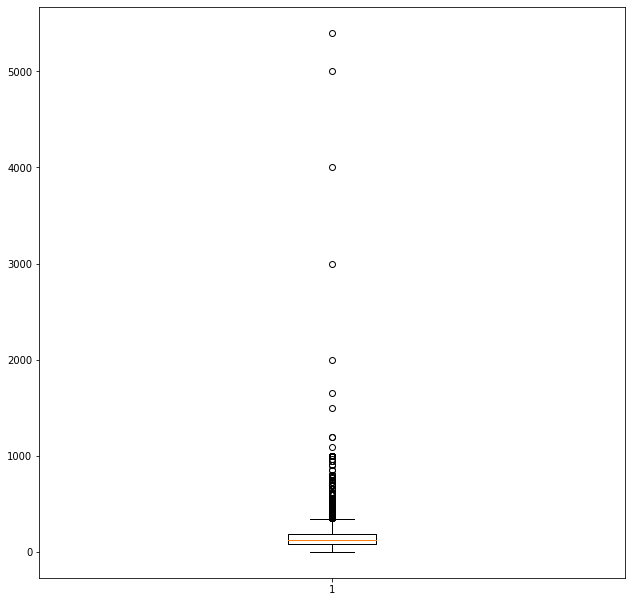

the 97 percentile is 600.0


In [1889]:
#visualize price distribution with box plot
from matplotlib import pyplot
pyplot.boxplot(price)
fig = pyplot.gcf()
fig.set_size_inches(10.5, 10.5)
pyplot.show()
#finding where 97% of the data lands.
print("the 97 percentile is",np.percentile(price, 97))

## 2 Model 

Split data into train & test

In [1890]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
#split missing solution 1 
X_train1, X_test1, y_train1, y_test1 = train_test_split(missing_solution_1, price, test_size=0.2, random_state=42)
#split missing solution 2 
X_train2, X_test2, y_train2, y_test2 = train_test_split(missing_solution_2, price, test_size=0.2, random_state=42)

Report for missing solution 1

In [1891]:
#first write down the formula without price, then add the price in for the sake of statsmodel library ols prediciton.
formulaStr = 'price~' + '+'.join(X_train1.columns)
X_train1['price'] = y_train1
#filter out price exceed 700. Outliers control 
#X_train1 = X_train1.loc[(X_train1['price'] <= 700)]
mod1 = smf.ols(formula=formulaStr, data=X_train1)
res1 = mod1.fit()
X_train1 = X_train1.drop(columns=['price'])
print(res1.summary())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     71.56
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:10:30   Log-Likelihood:                -38792.
No. Observations:                5984   AIC:                         7.768e+04
Df Residuals:                    5936   BIC:                         7.800e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [1892]:
haty1 = res1.predict(X_test1)
rmse1 = np.sqrt(np.mean((y_test1 - haty1)**2))
print(rmse1)

136.70991230965708


Report for missing solution 2

In [1893]:
#first write down the formula without price, then add the price in for the sake of statsmodel library ols prediciton.
formulaStr = 'price~' + '+'.join(X_train2.columns)
X_train2['price'] = y_train2
#filter out price exceed 700. Outliers control
#X_train2 = X_train2.loc[(X_train2['price'] <= 700)]
mod2 = smf.ols(formula=formulaStr, data=X_train2)
res2 = mod2.fit()
X_train2 = X_train2.drop(columns=['price'])
print(res2.summary())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     59.11
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:10:31   Log-Likelihood:                -38788.
No. Observations:                5984   AIC:                         7.769e+04
Df Residuals:                    5926   BIC:                         7.808e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [1894]:
haty2 = res2.predict(X_test2)
rmse2 = np.sqrt(np.mean((y_test2 - haty2)**2))
print(rmse2)

136.9008336103762


Test data from Ott

In [1895]:
testing_data = pd.read_csv('airbnb-seattle-listings-test.csv',sep='\t')
testing_data = narrowData(testing_data)

In [1896]:
testing_data = cleanData(testing_data)

KeyError: 'property_type'